In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt 

In [2]:
home = pd.read_csv('home_completed.csv')
away = pd.read_csv('away_completed.csv')

In [3]:
#put all data into one large data frame
main = home.append(away, ignore_index=True).sort_values(['Checker']) # puts into date order
#put columns into more organized order
main = main[['Year','Month', 'Day' , 'Team', 'Spread', 'Line', '+/-', '3P', '3P%', '3PA', '3PAr', 'AST', 'BLK', 'DRB', 'Day',
       'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'FTr', 'Home', 'Losses',
        'ORB', 'PF', 'PTS', 'STL', 'Starters MP', 'TOV', 'TS%', 'Wins',
        'eFG%',  'Checker']]
#number of points a team won or lost by
main['+/-'] = main['+/-']/5
#puts the odds into floats
main['Spread'] = main['Spread'].replace(' PK', '0').astype(float)
#gets how many points a team went over or under the spread
main['Cover'] = main['Spread'] + main['+/-']
#true or false on whether a team covered the spread
main['ATS'] = np.where(main['Cover'].isnull(), np.nan,
          np.where(main['Cover'] > 0,   1, 0))
teams = list(main['Team'])
new_teams = []
#adds the opponent to the df
for i in range(0, len(teams), 2):
    new_teams.append(teams[i+1])
    new_teams.append(teams[i])
main['Opponent'] = new_teams
main = main.dropna()

In [4]:
#function to create our engineered features for the team provided
def team_df(team):
    t = main[main['Team']== team].reset_index()
    del t['index']
    t['Season'] = t['Checker'].apply(season) #define what season a game is played
    t['Games Played'] = t['Wins'] + t['Losses'] #total games played
    #create running averages for all stats up to a given game date
    t_df = pd.DataFrame()
    for year in years:
        temp = t[t['Season']==year].reset_index()
        temp['Avg Win/Loss'] = (temp['+/-'].cumsum() - temp['+/-'])/temp.index
        temp['Avg 3P'] = (temp['3P'].cumsum() - temp['3P'])/temp.index
        temp['Avg 3PA'] = (temp['3PA'].cumsum() - temp['3PA'])/temp.index
        temp['Avg 3P%'] = (temp['Avg 3P']/temp['Avg 3PA'])
        temp['Avg Starter MP'] = (temp['Starters MP'].cumsum() - temp['Starters MP'])/temp.index
        temp['Avg AST'] = (temp['AST'].cumsum() - temp['AST'])/temp.index
        temp['Avg BLK'] = (temp['BLK'].cumsum() - temp['BLK'])/temp.index
        temp['Avg DRB'] = (temp['DRB'].cumsum() - temp['DRB'])/temp.index
        temp['Avg ORB'] = (temp['ORB'].cumsum() - temp['ORB'])/temp.index
        temp['Avg FG'] = (temp['FG'].cumsum() - temp['FG'])/temp.index
        temp['Avg FGA'] = (temp['FGA'].cumsum() - temp['FGA'])/temp.index
        temp['Avg FG%'] = (temp['Avg FG']/temp['Avg FGA'])
        temp['Avg FT'] = (temp['FT'].cumsum() - temp['FT'])/temp.index
        temp['Avg FTA'] = (temp['FTA'].cumsum() - temp['FTA'])/temp.index
        temp['Avg 3PAr'] = (temp['Avg 3PA']/temp['Avg FGA'])
        temp['Avg FTr'] = (temp['Avg FTA']/temp['Avg FGA'])
        temp['Avg 3P%'] = (temp['Avg FT']/temp['Avg FTA'])/temp.index
        temp['Avg PF'] = (temp['PF'].cumsum() - temp['PF'])/temp.index
        temp['Avg PTS'] = (temp['PTS'].cumsum() - temp['PTS'])/temp.index
        temp['Avg STL'] = (temp['STL'].cumsum() - temp['STL'])/temp.index
        temp['Avg TOV'] = (temp['TOV'].cumsum() - temp['TOV'])/temp.index
        temp['Avg TS%'] = temp['Avg PTS']/ (2*(temp['Avg FGA'] + .44 * temp['Avg FTA']))
        temp['Avg eFG%'] = (temp['Avg FG'] + .5 * temp['Avg 3P'])/ temp['Avg FGA']
        temp['Avg Starter MP'] = (temp['Starters MP'].cumsum() - temp['Starters MP'])/temp.index
        temp['Winning Percentage'] = temp['Wins']/temp.index
        temp['5 Game Win/Loss'] = temp['+/-'].rolling(5, min_periods=1).sum()-temp['+/-']
        temp['5 Game 3P'] = temp['3P'].rolling(5, min_periods=1).sum() - temp['3P']
        temp['5 Game 3PA'] = temp['3PA'].rolling(5, min_periods=1).sum()- temp['3PA']
        temp['5 Game 3P%'] = temp['5 Game 3P']/temp['5 Game 3PA']
        temp['5 Game Starter MP'] = temp['Starters MP'].rolling(5, min_periods=1).sum()-temp['Starters MP']
        temp['5 Game AST'] = temp['AST'].rolling(5, min_periods=1).sum() - temp['AST']
        temp['5 Game BLK'] = temp['BLK'].rolling(5, min_periods=1).sum() - temp['BLK']
        temp['5 Game DRB'] = temp['DRB'].rolling(5, min_periods=1).sum() - temp['DRB']
        temp['5 Game ORB'] = temp['ORB'].rolling(5, min_periods=1).sum() - temp['ORB']
        temp['5 Game FG'] = temp['FG'].rolling(5, min_periods=1).sum() - temp['FG']
        temp['5 Game FGA'] = temp['FGA'].rolling(5, min_periods=1).sum() - temp['FGA']
        temp['5 Game FG%'] = temp['5 Game FG']/temp['5 Game FGA']
        temp['5 Game FT'] = temp['FT'].rolling(5, min_periods=1).sum() - temp['FT']
        temp['5 Game FTA'] = temp['FTA'].rolling(5, min_periods=1).sum() - temp['FTA']
        temp['5 Game 3PAr'] = temp['5 Game 3PA']/temp['5 Game FGA']
        temp['5 Game FTr'] = temp['5 Game FTA']/temp['5 Game FGA']
        temp['5 Game 3P%'] = temp['5 Game FT']/temp['5 Game FTA']
        temp['5 Game PF'] = temp['PF'].rolling(5, min_periods=1).sum() - temp['PF']
        temp['5 Game PTS'] = temp['PTS'].rolling(5, min_periods=1).sum() - temp['PTS']
        temp['5 Game STL'] = temp['STL'].rolling(5, min_periods=1).sum() - temp['STL']
        temp['5 Game TOV'] = temp['TOV'].rolling(5, min_periods=1).sum() - temp['TOV']
        temp['5 Game TS%'] = temp['5 Game PTS']/ (2*(temp['5 Game FGA'] + .44 * temp['5 Game FTA']))
        temp['5 Game eFG%'] = (temp['5 Game FG'] + .5 * temp['5 Game 3P'])/ temp['5 Game FGA']
        t_df = t_df.append(temp)
    return t_df

In [5]:
#put each row into a season give the date of the game
def season(date):
    date = date[:6]
    if date < '200809':
        return '2007'
    elif date < '200909':
        return '2008'
    elif date < '201009':
        return '2009'
    elif date < '201109':
        return '2010'
    elif date < '201109':
        return '2010'
    elif date < '201209':
        return '2011'
    elif date < '201309':
        return '2012'
    elif date < '201409':
        return '2013'
    elif date < '201509':
        return '2014'
    elif date < '201609':
        return '2015'
    elif date < '201709':
        return '2016'
    elif date < '201809':
        return '2017'
    elif date < '201909':
        return '2018'

In [6]:
#store the teams
teams = set(teams)
years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
#hold data for each team in a dictionary where the key is the team and the value is the data
all_team_data = {}
for team in teams:
    all_team_data[team] = team_df(team)

In [7]:
#create one large data frame with all data from each team
giant_df = pd.DataFrame()
for df in all_team_data.values():
    giant_df = giant_df.append(df)

In [8]:
#add opponent game features to row of each game in its team specific dataframe
for team in teams:
    t = all_team_data[team]
    opp = giant_df[giant_df['Opponent']==team]
    opp = opp.rename(columns = {'Avg Win/Loss':'oppAvg Win/Loss', 'Avg 3P':'oppAvg 3P', 'Avg 3PA':'oppAvg 3PA' ,
       'Avg 3P%':'oppAvg 3P%', 'Avg Starter MP':'oppAvg Starter MP', 'Avg AST':'oppAvg AST', 'Avg BLK':'oppAvg BLK', 'Avg DRB':'oppAvg DRB', 'Avg ORB':'oppAvg ORB',
       'Avg FG':'oppAvg FG', 'Avg FGA':'oppAvg FGA', 'Avg FG%':'oppAvg FG%', 'Avg FT':'oppAvg FT', 'Avg FTA':'oppAvg FTA', 'Avg 3PAr':'oppAvg 3PAr',
       'Avg FTr':'oppAvg FTr', 'Avg PF':'oppAvg PF', 'Avg PTS':'oppAvg PTS', 'Avg STL':'oppAvg STL', 'Avg TOV':'oppAvg TOV', 'Avg TS%':'oppAvg TS%',
       'Avg eFG%':'oppAvg eFG%', 'Winning Percentage':'oppWinning Percentage'})
    opp = opp.rename(columns = {'5 Game Win/Loss':'opp 5 Game Win/Loss', '5 Game 3P':'opp 5 Game 3P', '5 Game 3PA':'opp 5 Game 3PA',
       '5 Game 3P%':'opp 5 Game 3P%', '5 Game Starter MP':'opp 5 Game Starter MP', '5 Game AST':'opp 5 Game AST', '5 Game BLK':'opp 5 Game BLK',
       '5 Game DRB':'opp 5 Game DRB', '5 Game ORB':'opp 5 Game ORB',
       '5 Game FG':'opp 5 Game FG', '5 Game FGA':'opp 5 Game FGA', '5 Game FG%':'opp 5 Game FG%', '5 Game FT':'opp 5 Game FT', '5 Game FTA':'opp 5 Game FTA', '5 Game 3PAr':'opp 5 Game 3PAr',
       '5 Game FTr':'opp 5 Game FTr', '5 Game PF':'opp 5 Game PF', '5 Game PTS':'opp 5 Game PTS', '5 Game STL':'opp 5 Game STL', '5 Game TOV':'opp 5 Game TOV', '5 Game TS%':'opp 5 Game TS%',
       '5 Game eFG%':'opp 5 Game eFG%'})
    opp = opp[['Checker', 'oppAvg Win/Loss', 'oppAvg 3P', 'oppAvg 3PA',
       'oppAvg 3P%', 'oppAvg Starter MP', 'oppAvg AST', 'oppAvg BLK',
       'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG', 'oppAvg FGA', 'oppAvg FG%',
       'oppAvg FT', 'oppAvg FTA', 'oppAvg 3PAr', 'oppAvg FTr', 'oppAvg PF',
       'oppAvg PTS', 'oppAvg STL', 'oppAvg TOV', 'oppAvg TS%', 'oppAvg eFG%',
       'oppWinning Percentage', 'opp 5 Game Win/Loss', 'opp 5 Game 3P', 'opp 5 Game 3PA',
       'opp 5 Game 3P%', 'opp 5 Game Starter MP', 'opp 5 Game AST', 'opp 5 Game BLK',
       'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game FGA', 'opp 5 Game FG%',
       'opp 5 Game FT', 'opp 5 Game FTA', 'opp 5 Game 3PAr', 'opp 5 Game FTr', 'opp 5 Game PF',
       'opp 5 Game PTS', 'opp 5 Game STL', 'opp 5 Game TOV', 'opp 5 Game TS%', 'opp 5 Game eFG%']]
    all_team_data[team] = pd.merge(t,opp)

In [9]:
#Philadelphia feature matrix
phi = all_team_data['Philadelphia']

In [10]:
#get necesarry data from phi matrix
total_matrix = phi[['Cover', 'ATS', '+/-', 'Wins', 'Losses', 'Home', 'Avg Win/Loss', 'Avg 3P',
       'Avg 3PA', 'Avg 3P%', 'Avg Starter MP', 'Avg AST', 'Avg BLK', 'Avg DRB',
       'Avg ORB', 'Avg FG', 'Avg FGA', 'Avg FG%', 'Avg FT', 'Avg FTA',
       'Avg 3PAr', 'Avg FTr', 'Avg PF', 'Avg PTS', 'Avg STL', 'Avg TOV',
       'Avg TS%', 'Avg eFG%', 'Winning Percentage', 'oppAvg Win/Loss','oppAvg 3P',
        'oppAvg 3PA', 'oppAvg 3P%', 'oppAvg Starter MP',
        'oppAvg AST', 'oppAvg BLK', 'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG',
        'oppAvg FGA', 'oppAvg FG%', 'oppAvg FT', 'oppAvg FTA', 'oppAvg 3PAr',
        'oppAvg FTr', 'oppAvg PF', 'oppAvg PTS', 'oppAvg STL', 'oppAvg TOV',
        'oppAvg TS%', 'oppAvg eFG%', 'oppWinning Percentage', '5 Game Win/Loss', '5 Game 3P', '5 Game 3PA',
       '5 Game 3P%', '5 Game Starter MP', '5 Game AST', '5 Game BLK',
       '5 Game DRB', '5 Game ORB', '5 Game FG', '5 Game FGA', '5 Game FG%',
       '5 Game FT', '5 Game FTA', '5 Game 3PAr', '5 Game FTr', '5 Game PF',
       '5 Game PTS', '5 Game STL', '5 Game TOV', '5 Game TS%', '5 Game eFG%',
       'opp 5 Game Win/Loss', 'opp 5 Game 3P', 'opp 5 Game 3PA',
       'opp 5 Game 3P%', 'opp 5 Game Starter MP', 'opp 5 Game AST', 'opp 5 Game BLK',
       'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game FGA', 'opp 5 Game FG%',
       'opp 5 Game FT', 'opp 5 Game FTA', 'opp 5 Game 3PAr', 'opp 5 Game FTr', 'opp 5 Game PF',
       'opp 5 Game PTS', 'opp 5 Game STL', 'opp 5 Game TOV', 'opp 5 Game TS%', 'opp 5 Game eFG%']]
total_matrix = total_matrix.dropna()

In [11]:
#create philadelphia feature_matrix
feature_matrix = total_matrix[['Wins', 'Losses', 'Home', 'Avg Win/Loss', 'Avg 3P',
       'Avg 3PA', 'Avg Starter MP', 'Avg AST', 'Avg BLK', 'Avg DRB',
       'Avg ORB', 'Avg FG', 'Avg FGA',
       'Avg 3PAr', 'Avg FTr', 'Avg PF', 'Avg PTS', 'Avg STL', 'Avg TOV',
       'Avg eFG%', 'oppAvg Win/Loss','oppAvg 3P',
        'oppAvg 3PA', 'oppAvg Starter MP',
        'oppAvg AST', 'oppAvg BLK', 'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG',
        'oppAvg FGA', 'oppAvg 3PAr',
        'oppAvg FTr', 'oppAvg PF', 'oppAvg PTS', 'oppAvg STL', 'oppAvg TOV',
        'oppAvg eFG%', 'oppWinning Percentage', '5 Game Win/Loss', '5 Game 3P', '5 Game 3PA',
       '5 Game Starter MP', '5 Game AST', '5 Game BLK',
       '5 Game DRB', '5 Game ORB', '5 Game FG', '5 Game FGA', 
       '5 Game 3PAr', '5 Game FTr', '5 Game PF',
       '5 Game PTS', '5 Game STL', '5 Game TOV', '5 Game eFG%',
       'opp 5 Game Win/Loss', 'opp 5 Game 3P', 'opp 5 Game 3PA',
       'opp 5 Game Starter MP', 'opp 5 Game AST', 'opp 5 Game BLK',
       'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game FGA', 
       'opp 5 Game 3PAr', 'opp 5 Game FTr', 'opp 5 Game PF',
       'opp 5 Game PTS', 'opp 5 Game STL', 'opp 5 Game TOV', 'opp 5 Game eFG%']]

In [12]:
len(feature_matrix.columns)

72

In [13]:
results = total_matrix['+/-']
#create target matrix 
# 0 = loss, 1 = win
temp_target = results.values

In [14]:
#function to create a target matrix given the +/- of the game
def create_target(temp_target):
    target = []
    for result in temp_target:
        if result < 0:
            target.append(0)
        elif result >= 0:
            target.append(1)
    return target
target = create_target(temp_target)

In [15]:
#split the philalphia data into training and testing data
feature_train, feature_test, target_train, target_test = train_test_split(feature_matrix, target, test_size=0.25, random_state=42)

In [16]:
#Create and train a decision tree model
DTmodel = tree.DecisionTreeClassifier()
DTmodel = DTmodel.fit(feature_train, target_train)

In [17]:
predict = DTmodel.predict(feature_test)

In [18]:
accuracy = accuracy_score(target_test, predict)
accuracy

0.6428571428571429

**Parameter tuning for Decision Tree Classifier:**
<br> See if we can improve the accuracy of the decision tree

In [19]:
max_depths = np.linspace(1, 50, 50)

In [20]:
min_samples_split = np.linspace(0.1, 1.0, 10)

In [21]:
min_samples_leaf = np.linspace(0.1, .5, 10)

In [22]:
depth = 0
split = 0
leaf = 0 
max_acc = 0
#store the best tree created
best_tree = tree.DecisionTreeClassifier()
for x in max_depths:
    for y in min_samples_split:
        for z in min_samples_leaf:
                model = tree.DecisionTreeClassifier(max_depth=x, min_samples_split = y, min_samples_leaf=z)
                model = model.fit(feature_train, target_train)
                predict = model.predict(feature_test)
                acc = accuracy_score(target_test, predict)
                if acc > max_acc:
                    max_acc = acc
                    best_tree = model
                    depth, split, leaf = x, y, z

In [23]:
max_acc

0.7478991596638656

In [24]:
depth, split, leaf

(4.0, 0.30000000000000004, 0.1)

In [25]:
#The code below from: 
#https://stackoverflow.com/questions/25274673/is-it-possible-to-print-the-decision-tree-in-scikit-learn
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO() 
tree.export_graphviz(best_tree, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

graph[0].write_pdf("tree.pdf")

#This creates a pdf showing the decision tree created by the classifier. 

In [26]:
#get important features from tree
important = best_tree.feature_importances_
len(important)
cols = np.array(feature_matrix.columns)

for c in cols:
    if important[np.where(cols == c)] > 0:
        print(c)

Home
Avg Win/Loss
oppAvg Win/Loss
5 Game Win/Loss


In [27]:
feature_matrix_shots = feature_matrix[['Avg DRB', 'Avg ORB', 'Avg FG', 'Avg TOV', 'Avg eFG%',
        'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG','oppAvg TOV','oppAvg eFG%',
        '5 Game DRB', '5 Game ORB', '5 Game FG', '5 Game TOV', '5 Game eFG%',
         'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game TOV', 'opp 5 Game eFG%']]
feature_train_shots, feature_test_shots, target_train_shots, target_test_shots = train_test_split(feature_matrix_shots, target, test_size=0.25, random_state=42)

In [36]:
model = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split = split, min_samples_leaf=leaf)
model = model.fit(feature_train_shots, target_train_shots)
predict_shots = model.predict(feature_test_shots)
acc_shots = accuracy_score(target_test_shots, predict_shots)

In [37]:
depth_s = 0
split_s = 0
leaf_s = 0
max_acc = 0
best_tree_shots = tree.DecisionTreeClassifier()
for x in max_depths:
    for y in min_samples_split:
        for z in min_samples_leaf:
                model = tree.DecisionTreeClassifier(max_depth=x, min_samples_split = y, min_samples_leaf=z)
                model = model.fit(feature_train_shots, target_train_shots)
                predict = model.predict(feature_test_shots)
                acc = accuracy_score(target_test_shots, predict)
                if acc > max_acc:
                    max_acc = acc
                    best_tree_shots = model
                    depth_s, split_s, leaf_s = x, y, z

In [38]:
print(max_acc)
print(depth_s)
print(split_s)
print(leaf_s)

0.680672268907563
4.0
0.1
0.1


In [39]:
important = best_tree_shots.feature_importances_
len(important)
cols = np.array(feature_matrix_shots.columns)

for c in cols:
    if important[np.where(cols == c)] > 0:
        print(c)

Avg DRB
Avg TOV
Avg eFG%
oppAvg DRB
oppAvg eFG%
5 Game FG
opp 5 Game TOV


**Random forest classifier:**

In [51]:
RFmodel = RandomForestClassifier(n_estimators = 100)
RFmodel = RFmodel.fit(feature_train, target_train)
RFpredict = RFmodel.predict(feature_test)

In [52]:
acc = accuracy_score(target_test, RFpredict)
acc

0.6974789915966386

In [55]:
maxAcc = 0
est = 0
best_forest = RandomForestClassifier()
for i in range(1,100):
    RFmodel = RandomForestClassifier(n_estimators=i)
    RFmodel = RFmodel.fit(feature_train, target_train)
    RFpredict = RFmodel.predict(feature_test)
    acc = accuracy_score(target_test, RFpredict)
    if acc > maxAcc:
        maxAcc = acc
        est = i
        best_forest = RFmodel

In [56]:
print(maxAcc)
print(est)

0.7478991596638656
54


In [57]:
maxAcc = 0
est = 0
best_forest_shots = RandomForestClassifier()
for i in range(1,100):
    RFmodel = RandomForestClassifier(n_estimators=i)
    RFmodel = RFmodel.fit(feature_train_shots, target_train_shots)
    RFpredict = RFmodel.predict(feature_test_shots)
    acc = accuracy_score(target_test_shots, RFpredict)
    if acc > maxAcc:
        maxAcc = acc
        est = i
        best_forest_shots = RFmodel

In [58]:
print(maxAcc)

0.7226890756302521


In [59]:
#PHL TREE
phl_tree = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split = split, min_samples_leaf=leaf)
phl_tree = phl_tree.fit(feature_matrix, target)

#PHL FOREST
phl_forest = RandomForestClassifier(n_estimators=est)
phl_forest = phl_forest.fit(feature_matrix, target)

In [60]:
#create feature matrix and target matrix for the input team
def get_team_data(team):
    stats = all_team_data[team]
    stats = stats.dropna()
    feature_matrix = stats[['Wins', 'Losses', 'Home', 'Avg Win/Loss', 'Avg 3P',
       'Avg 3PA', 'Avg Starter MP', 'Avg AST', 'Avg BLK', 'Avg DRB',
       'Avg ORB', 'Avg FG', 'Avg FGA',
       'Avg 3PAr', 'Avg FTr', 'Avg PF', 'Avg PTS', 'Avg STL', 'Avg TOV',
       'Avg eFG%', 'oppAvg Win/Loss','oppAvg 3P',
        'oppAvg 3PA', 'oppAvg Starter MP',
        'oppAvg AST', 'oppAvg BLK', 'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG',
        'oppAvg FGA', 'oppAvg 3PAr',
        'oppAvg FTr', 'oppAvg PF', 'oppAvg PTS', 'oppAvg STL', 'oppAvg TOV',
        'oppAvg eFG%', 'oppWinning Percentage', '5 Game Win/Loss', '5 Game 3P', '5 Game 3PA',
       '5 Game Starter MP', '5 Game AST', '5 Game BLK',
       '5 Game DRB', '5 Game ORB', '5 Game FG', '5 Game FGA', 
       '5 Game 3PAr', '5 Game FTr', '5 Game PF',
       '5 Game PTS', '5 Game STL', '5 Game TOV', '5 Game eFG%',
       'opp 5 Game Win/Loss', 'opp 5 Game 3P', 'opp 5 Game 3PA',
       'opp 5 Game Starter MP', 'opp 5 Game AST', 'opp 5 Game BLK',
       'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game FGA', 
       'opp 5 Game 3PAr', 'opp 5 Game FTr', 'opp 5 Game PF',
       'opp 5 Game PTS', 'opp 5 Game STL', 'opp 5 Game TOV', 'opp 5 Game eFG%']]
    results = stats[['+/-']]
    results = results.values
    target = create_target(results)
    return feature_matrix, target

In [61]:
#create feature matrix and target matrix for the input team for a specific season
def get_team_season_data(team, year):
    stats = all_team_data[team]
    season_stats = stats.loc[stats['Season'] == year]
    season_stats = season_stats.dropna()
    feature_matrix = season_stats[['Wins', 'Losses', 'Home', 'Avg Win/Loss', 'Avg 3P',
       'Avg 3PA', 'Avg Starter MP', 'Avg AST', 'Avg BLK', 'Avg DRB',
       'Avg ORB', 'Avg FG', 'Avg FGA',
       'Avg 3PAr', 'Avg FTr', 'Avg PF', 'Avg PTS', 'Avg STL', 'Avg TOV',
       'Avg eFG%', 'oppAvg Win/Loss','oppAvg 3P',
        'oppAvg 3PA', 'oppAvg Starter MP',
        'oppAvg AST', 'oppAvg BLK', 'oppAvg DRB', 'oppAvg ORB', 'oppAvg FG',
        'oppAvg FGA', 'oppAvg 3PAr',
        'oppAvg FTr', 'oppAvg PF', 'oppAvg PTS', 'oppAvg STL', 'oppAvg TOV',
        'oppAvg eFG%', 'oppWinning Percentage', '5 Game Win/Loss', '5 Game 3P', '5 Game 3PA',
       '5 Game Starter MP', '5 Game AST', '5 Game BLK',
       '5 Game DRB', '5 Game ORB', '5 Game FG', '5 Game FGA', 
       '5 Game 3PAr', '5 Game FTr', '5 Game PF',
       '5 Game PTS', '5 Game STL', '5 Game TOV', '5 Game eFG%',
       'opp 5 Game Win/Loss', 'opp 5 Game 3P', 'opp 5 Game 3PA',
       'opp 5 Game Starter MP', 'opp 5 Game AST', 'opp 5 Game BLK',
       'opp 5 Game DRB', 'opp 5 Game ORB', 'opp 5 Game FG', 'opp 5 Game FGA', 
       'opp 5 Game 3PAr', 'opp 5 Game FTr', 'opp 5 Game PF',
       'opp 5 Game PTS', 'opp 5 Game STL', 'opp 5 Game TOV', 'opp 5 Game eFG%']]
    results = season_stats[['+/-']]
    results = results.values
    target = create_target(results)
    return feature_matrix, target

In [62]:
#Try model on other teams
def predict_team(model, team):
    feature, target = get_team_data(team)
    predict = model.predict(feature)
    acc = accuracy_score(target, predict)
    return acc

In [63]:
#Try model on other teams by season
def predict_team_season(model, team, year):
    feature, target = get_team_season_data(team, year)
    predict = model.predict(feature)
    acc = accuracy_score(target, predict)
    return acc

In [64]:
#see how well the Philadelphia model can predict outcome of other teams
tree_accuracies = []
forest_accuracies = []
for team in teams:
    if team != "Philadelphia":
        tree_acc = predict_team(phl_tree, team)
        forest_acc = predict_team(phl_forest, team)
        tree_accuracies.append(tree_acc)
        forest_accuracies.append(forest_acc)

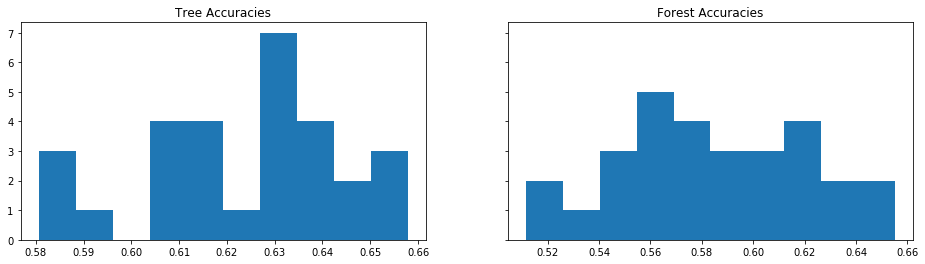

In [65]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,4))

ax[0].hist(tree_accuracies)
ax[0].set_title("Tree Accuracies")

ax[1].hist(forest_accuracies)
ax[1].set_title("Forest Accuracies")

plt.show()

In [66]:
print("Max tree accuracy " + str(max(tree_accuracies)))
print("Min tree accuracy " + str(min(tree_accuracies)))
print("Max forest accuracy " + str(max(forest_accuracies)))
print("Min forest accuracy " + str(min(forest_accuracies)))

Max tree accuracy 0.6578947368421053
Min tree accuracy 0.5806794055201698
Max forest accuracy 0.6551204819277109
Min forest accuracy 0.5116279069767442


In [67]:
#create tree and forest models using data for input team and season (year)
def season_model(team, year):
    feature_matrix, target = get_team_season_data(team, year)
    tree_model = tree.DecisionTreeClassifier(max_depth=depth, min_samples_split =split, min_samples_leaf=leaf)
    tree_model = tree_model.fit(feature_matrix, target)
    
    forest_model = RandomForestClassifier(n_estimators=i)
    forest_model = forest_model.fit(feature_matrix, target)
    
    return (tree_model,forest_model)

In [68]:
#see if previous season can be used to accurately predict next season
years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
phl_seasons = {}
for year in years:
    (tree_model, forest_model) = season_model('Philadelphia', year)
    phl_seasons[year] = (tree_model, forest_model)

In [69]:
years_test = years[1:]
i = 0
#use phl_seasons dictionary created in above cell to predict outcomes of season with the previous season
tree_accuracies = {}
forest_accuracies = {}

for year in years_test:
    tree_acc = predict_team_season(phl_seasons[years[i]][0], "Philadelphia", year)       
    forest_acc = predict_team_season(phl_seasons[years[i]][1], "Philadelphia", year)

    tree_accuracies[year] = tree_acc
    forest_accuracies[year] = forest_acc
    i += 1

In [83]:
#Predict model on teams by season, return 2 lists, one of game count and one if prediction was correct
def predict_team_season_plot(model, team, year):
    feature, target = get_team_season_data(team, year)
    predict = model.predict(feature)
    gamecount = list(range(len(target)))
    correct = []
    for i in gamecount:
        if predict[i] == target[i]:
            #correct
            correct.append(1)
        else:
            #incorrect
            correct.append(0)
    return correct, gamecount

In [84]:
correctness = {}
gamecount = {}
i = 0
for year in years_test:
    correctness[year], gamecount[year] = predict_team_season_plot(phl_seasons[years[i]][0], "Philadelphia", year)       
    i += 1

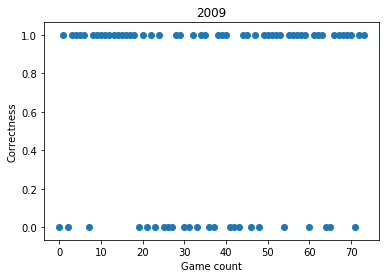

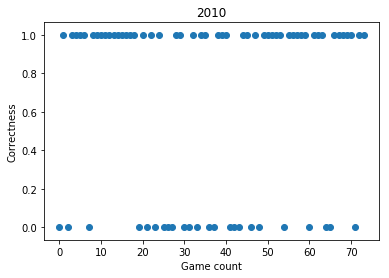

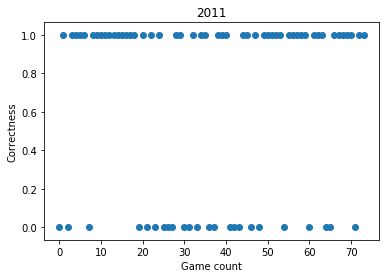

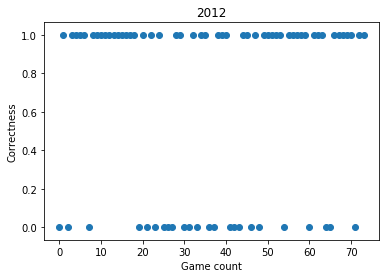

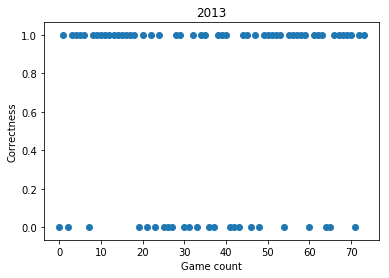

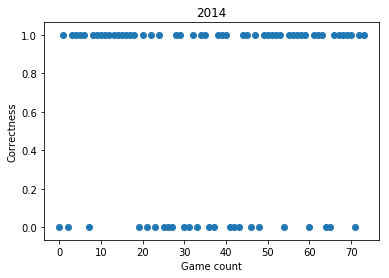

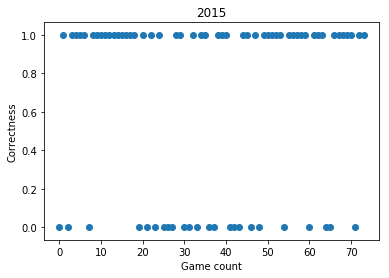

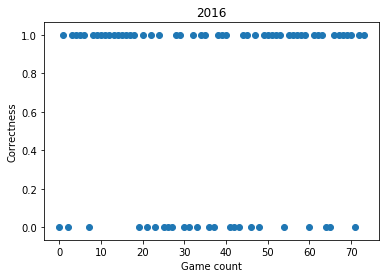

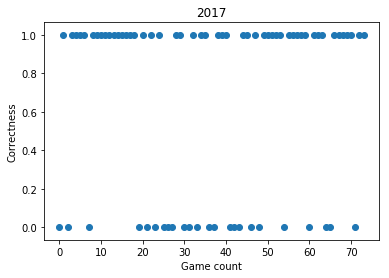

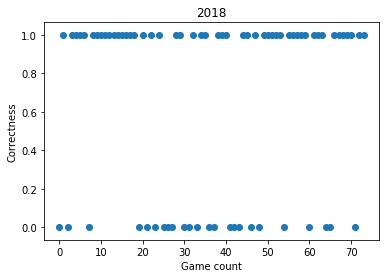

In [93]:
for year in years_test:
    plt.scatter(gamecount['2009'], correctness['2009'])
    plt.title(year)
    plt.xlabel('Game count')
    plt.ylabel('Correctness')
    plt.show()

In [70]:
tree_accuracies

{'2009': 0.6756756756756757,
 '2010': 0.5384615384615384,
 '2011': 0.5068493150684932,
 '2012': 0.6025641025641025,
 '2013': 0.43037974683544306,
 '2014': 0.6296296296296297,
 '2015': 0.7283950617283951,
 '2016': 0.654320987654321,
 '2017': 0.38461538461538464,
 '2018': 0.6266666666666667}

In [71]:
forest_accuracies

{'2009': 0.5945945945945946,
 '2010': 0.47435897435897434,
 '2011': 0.4794520547945205,
 '2012': 0.5256410256410257,
 '2013': 0.35443037974683544,
 '2014': 0.7407407407407407,
 '2015': 0.8765432098765432,
 '2016': 0.654320987654321,
 '2017': 0.3626373626373626,
 '2018': 0.64}

In [72]:
from collections import defaultdict
tree_accuracies_season = defaultdict(list)
forest_accuracies_season = defaultdict(list)
for team in teams:
    if team != "Philadelphia":
        for year in years:
            tree_acc = predict_team_season(phl_seasons[year][0], team, year)
            forest_acc = predict_team_season(phl_seasons[year][1], team, year)
            tree_accuracies_season[year].append(tree_acc)
            forest_accuracies_season[year].append(forest_acc)

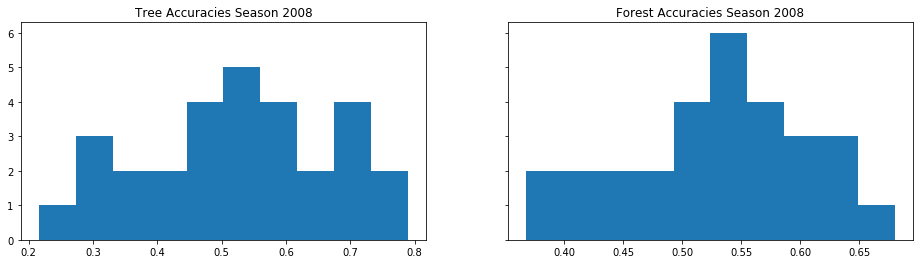

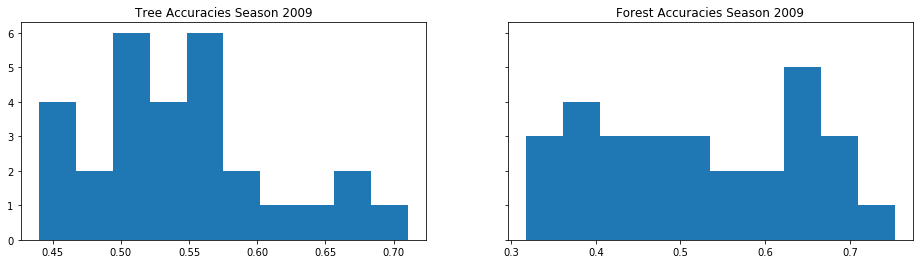

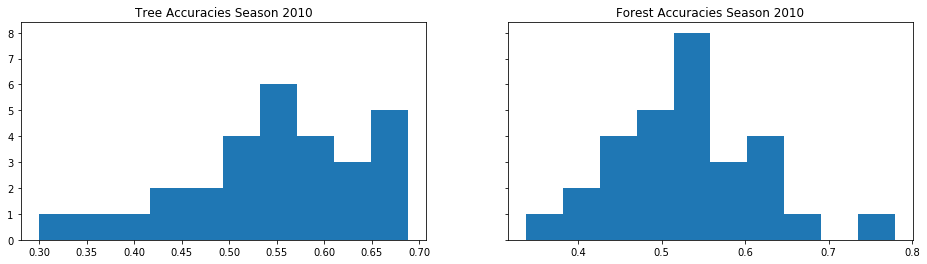

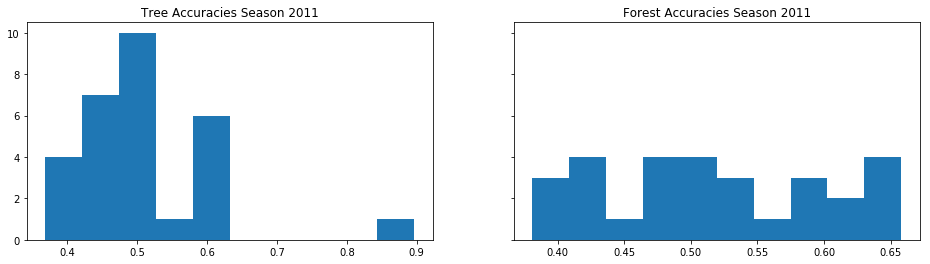

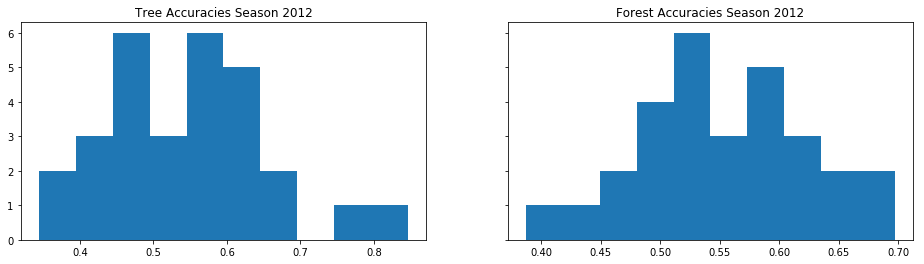

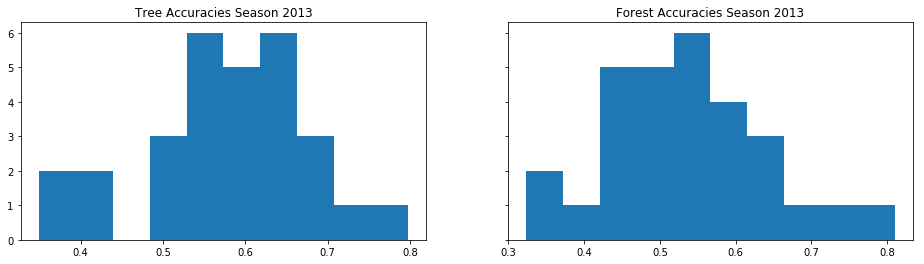

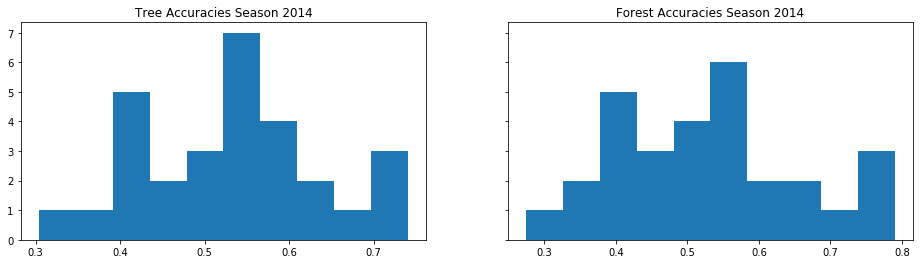

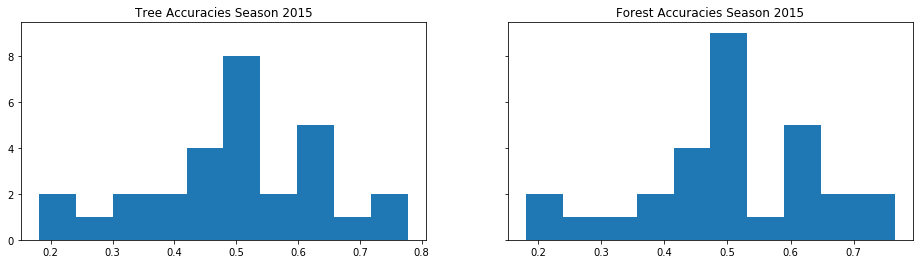

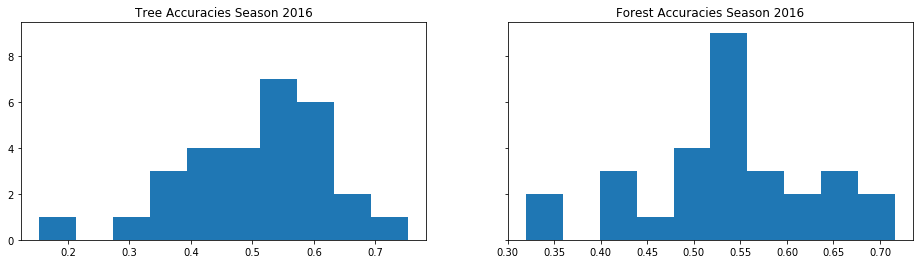

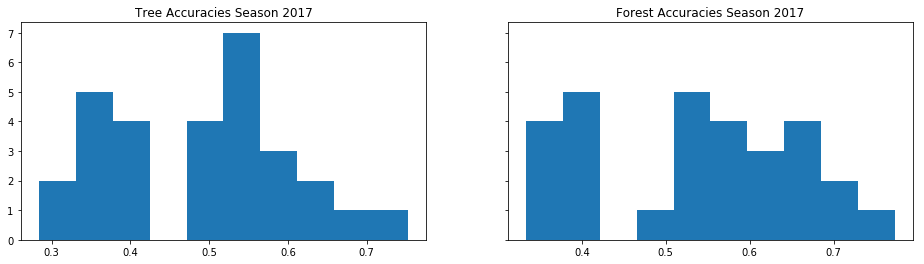

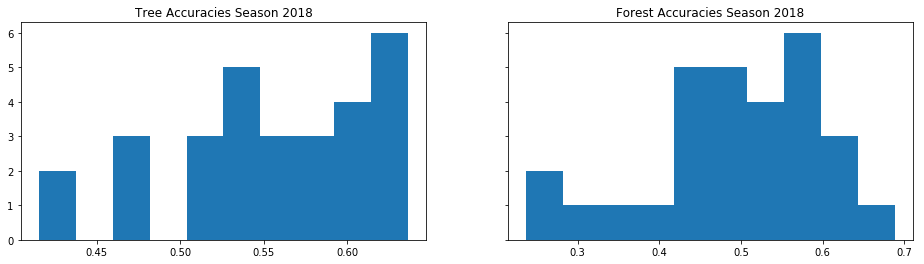

In [73]:
plots = {}
#accuracy of models fit to philadelphia data from each season can predict other teams for the season
for year in years:
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,4))
    ax[0].hist(tree_accuracies_season[year])
    ax[0].set_title("Tree Accuracies Season " + year)

    ax[1].hist(forest_accuracies_season[year])
    ax[1].set_title("Forest Accuracies Season " + year)
    plots[year] = (fig, ax)

In [74]:
#get important features for the season models
import collections
def season_importances(models):
    tree_important = []
    for year in years:
        tree_model = models[year][0]
        important_tree = tree_model.feature_importances_
        cols = np.array(feature_matrix.columns)
        for c in cols:
            if important_tree[np.where(cols == c)] > 0:
                tree_important.append(c)
    tree_counter = collections.Counter(tree_important)
    return tree_counter

tree_imp = season_importances(phl_seasons)
tree_imp

Counter({'Avg ORB': 3,
         'oppAvg FG': 1,
         'oppAvg STL': 1,
         'oppWinning Percentage': 4,
         'oppAvg DRB': 1,
         'oppAvg FGA': 1,
         '5 Game FTr': 2,
         'opp 5 Game Win/Loss': 4,
         'Losses': 1,
         'oppAvg AST': 2,
         '5 Game eFG%': 1,
         'oppAvg TOV': 1,
         'oppAvg eFG%': 1,
         'opp 5 Game STL': 1,
         'Avg FG': 1,
         'oppAvg BLK': 2,
         'Avg 3PAr': 1,
         'oppAvg PTS': 1,
         '5 Game PF': 1,
         'opp 5 Game AST': 1,
         'opp 5 Game FGA': 1,
         'Avg eFG%': 1,
         '5 Game STL': 1,
         'Avg 3PA': 1,
         'opp 5 Game ORB': 1,
         'opp 5 Game eFG%': 1,
         'Avg TOV': 1,
         'oppAvg 3P': 1,
         'oppAvg Starter MP': 1,
         '5 Game DRB': 1,
         '5 Game FG': 1})